## Import  necessary Libraries

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from math import sqrt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

## Problem statement
- Forecasting weather in near future is a very important task. 
- Purposes: It helps us to plan our day accordingly.

   In this problem, we are going to predict the weather for the next 7 days. We are given the weather data of the past 3 months. We will use this data to train our model and then predict the weather for the next 7 days.


## Data prerations

In [5]:
# read pre_processed data
df = pd.read_csv('../data/processed/processed_data.csv')
df.head()

,datetime,temp (K),feels_like,pressure,humidity,temp_min,temp_max,wind_speed,wind_deg,clouds_all,id_weather,main_weather,description_weather,icon_weather
0,2022-12-09 17:00:00,299.16,299.16,1010.0,94.0,299.16,299.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n
1,2022-12-09 18:00:00,299.16,299.16,1009.0,94.0,299.16,299.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n
2,2022-12-09 19:00:00,298.16,299.33,1009.0,100.0,298.16,298.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n
3,2022-12-09 20:00:00,298.16,298.88,1008.0,83.0,298.16,298.16,1.03,20.0,40.0,802.0,Clouds,scattered clouds,03n
4,2022-12-09 21:00:00,298.16,298.88,1008.0,83.0,298.16,298.16,1.03,50.0,40.0,802.0,Clouds,scattered clouds,03n


### Splitting the data into train and test set

In [13]:
#split data into train and test
df_copy = df.drop(columns=['icon_weather','main_weather','description_weather','id_weather','datetime'])
x_train,x_test,y_train,y_test = train_test_split(df_copy,df['temp (K)'],test_size=0.2,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((6969, 9), (1743, 9), (6969,), (1743,))

## Polynomial Regression Model

In [4]:
# train model Polynomial Regression
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(x_train, y_train)
coefficients = model.named_steps['linearregression'].coef_
for feature, coef in zip(df_copy.columns, coefficients):
    print(f"Coefficient for {feature}: {coef.round(3)}")

Coefficient for temp (K): -0.0
Coefficient for feels_like: 0.333
Coefficient for pressure: 0.0
Coefficient for humidity: -0.0
Coefficient for temp_min: -0.0
Coefficient for temp_max: 0.333
Coefficient for wind_speed: 0.333
Coefficient for wind_deg: 0.0
Coefficient for clouds_all: -0.0


## Metrics: MSE

In [35]:
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred = model.predict(x_test)
# metric
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.005


Visualizing the results

In [18]:
#visualize the results
import matplotlib.pyplot as plt
plt.plot(y_test, y_pred, '.')
plt.title('Polynomial Regression')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


NameError: name 'y_pred' is not defined

$$\text{temp (K)} = 0.333*\text{feels like} + 0.333*\text{temp max} + 0.333*\text{wind speed}$$

## ARIMA (Auto Regressive Integrated Moving Average) Model

In [37]:
# model ARIMA(AutoRegressive Integrated Moving Average)

# split data into train and test sets
X = df['temp (K)'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1.164


In [17]:
# Model ARIMA(AutoRegressive Integrated Moving Average)
history = list(y_train)
predictions = list()

# Walk-forward validation
for t in range(len(y_test)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test.iloc[t]
    history.append(obs)

# Evaluate forecasts
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.373


In [44]:
# Truy cập tất cả các hệ số
all_coefs = model_fit.params
print(all_coefs)

[0.18102282 0.17507519 1.27815252]


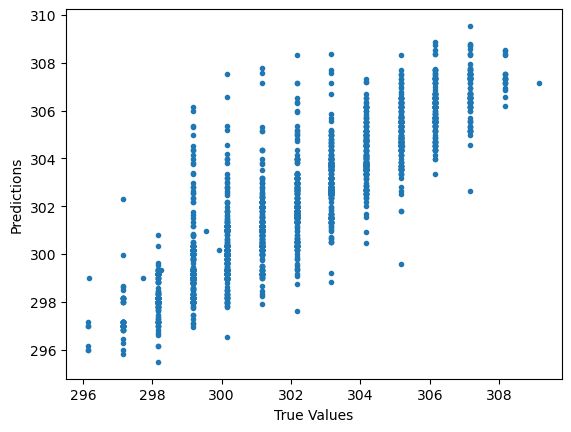

In [31]:
#visualize the results
plt.plot(test, predictions, '.')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()